## Solving differential equations using Neural networks

In this project, we attempt to solve ordinary differntial equations using Neural Networks. The Cybenko theorem states that an aritifical neural network with one hidden layer can approximate any continuous function on $\mathbb{R}^n$ under some mild assumptions on the activate function (for example the Sigmoid activation function). In essence we can discreteize the domain and try and minimize a trial solution involving terms that satsify the boundary condition as well as the output of a neural network. We then need to optimize the parameters such that the LHS of the differential equation written as LHS  = 0 is minimized. The inputs are different discretized points in the domain over which we seek the solution.  

See this paper here for a preliminary introduction: http://cs229.stanford.edu/proj2013/ChiaramonteKiener-SolvingDifferentialEquationsUsingNeuralNetworks.pdf

### Basic Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from tqdm import tqdm

In this example, we are going to solve the 2D Laplace equation $\nabla^2 \psi(x) = 0$ over the domain $(x_1, x_2) \in [0,1] \times [0,1]$ under the boundary conditions $\psi(x) = 0 $ when $x_1=0, x_1=1$ and $x_2=0$, and $\psi(x)=\sin \pi x$ when $x_2 = 1$ for all $x_1$. First we discretize the domain and create a meshgrid of points. We will convert the meshgrid into a numpy array of tuples so that we can later use this is a DataLoader object to generate this one by one rather than holding them all in memory. It also helps us implement batching nicely.

In [2]:
N = 250

x1 = np.linspace(0, 1, N, endpoint=True)
x2 = np.linspace(0, 1, N, endpoint=True)

X1, X2 = np.meshgrid(x1, x2)
pts = np.vstack([X1.ravel(), X2.ravel()]).T

Next define a dataset class and create the dataloader object

In [3]:
class pt_generator(Dataset):

    def __init__(self, pts):
        super(pt_generator, self).__init__()
        self.pts = pts

    def __len__(self):
        return self.pts.shape[0]

    def __getitem__(self, idx):
        p = torch.Tensor([self.pts[idx]])
        o = torch.ones((1,1))
        t = torch.cat((p, o), dim=-1).view(-1, 3) # Adding a bias terms to capture constants in the solution
        t.requires_grad_(True)
        return t 

pt_dataset = pt_generator(pts)
pt_dataloader = DataLoader(pt_dataset, batch_size=1, shuffle=True) # WE will start with just a batch size of 1

Next, we define the structure of the neural network. We choose one hidden layer with 16 neurons

In [4]:
class NET(nn.Module):

    def __init__(self):
        super(NET, self).__init__()

        self.i2h = nn.Linear(3, 16)
        self.h2o = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1)
        x = self.sigmoid(self.i2h(x))
        x = self.h2o(x)
        return x

net = NET()

optimizer = optim.SGD(net.parameters(), lr=.01)

In [5]:
def objective_fn(x):
    """
        We first need to be able to calculate the ojective function,
        which involves the derivatives of the equation LHS=0
        with respect to inputs. In fact we need the second order derivatives 
    """
    x1 = x.view(-1)[0]
    x2 = x.view(-1)[1]
    # The solution below was constructed based on knowledge of the boundary conditions
    sol = x2*torch.sin(np.pi * x1) + x1*(1-x1)*x2*(1-x2)*net(x)
    # print(sol)
    gradient = torch.autograd.grad(sol, x, create_graph=True, retain_graph=True)[0].view(3, 1)
    dx, dy, dc = gradient[0], gradient[1], gradient[2]
    second_x_deriv = torch.autograd.grad(dx, x1, create_graph=True, retain_graph=True)[0]
    second_y_deriv = torch.autograd.grad(dy, x2, create_graph=True, retain_graph=True)[0]
    laplacian = (second_x_deriv + second_y_deriv)**2
    return laplacian.view(1, -1)
    # print('Does dx require grad?', dx.requires_grad)
    # laplacian = torch.autograd.grad(gradient, x, retain_graph=True)
    # return laplacian


In [6]:
def train():
    total_loss = 0
    # counter = 0
    for x in tqdm(pt_dataloader):
        optimizer.zero_grad()
        loss = objective_fn(x)
        total_loss += loss
        loss.backward()
        optimizer.step()
        # if counter%2500 == 0:
        #     print('iteration: ', counter, 'loss: ', total_loss/25)
        #     total_loss = 0
        # counter += 1
    return None

In [7]:
train()

  0%|          | 0/62500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 62500/62500 [02:32<00:00, 409.02it/s]


In [8]:
torch.save(net.state_dict(), './neural-pde-trained.pt')

net_loaded = NET()
net_loaded.load_state_dict(torch.load('./neural-pde-trained.pt'))
net_loaded.eval()

NET(
  (i2h): Linear(in_features=3, out_features=16, bias=True)
  (h2o): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [9]:
def solution_generator():
    with torch.no_grad():
        N = 500
        X = np.linspace(0, 1, N, endpoint=True)
        Y = np.linspace(0, 1, N, endpoint=True)
        image = np.empty((500, 500))
        for i, x in tqdm(enumerate(X)):
            for j, y in enumerate(Y):
                image[j, i] = y*np.sin(np.pi * x) + x*(1-x)*y*(1-y)*(net_loaded(torch.Tensor([x, y, 1]))).item() 
        return image

Below we plot this solution of the Laplace equation on a square of side 1

500it [00:14, 35.59it/s]


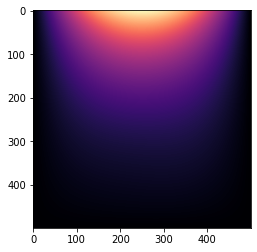

In [10]:
im = solution_generator()
im_flipped = np.flip(im, axis=0)
plt.imshow(im_flipped, cmap='magma')
plt.show()

It can be shown that this solution is very close to the full analytical solution for this problem. The advantage of using this approach is that there is a great speed up in solving the equations this way vs. doing the full blown numerical solution using finite difference or other schemes. We will be applying this technique to more complicated problems in the future and measure how much more efficient this approach can be in specific situations. 